# Analyse de trajectoires à l'aide de fichiers .gpx

Ce notebook sert à analyser des trajectoires en vélo. Il permet de déterminer la puissance mécanique transférée par le cycliste au vélo.

In [91]:
import pandas as pd
import pylab
import gpxpy
import gpxpy.gpx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from math import factorial

import folium
from folium import plugins, IFrame
from folium.features import *

import os
from pandas import DataFrame
dir = os.path.dirname(os.path.realpath('__file__'))
pylab.rcParams['figure.figsize'] = (24.0, 12.0) #configure the figure

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def lon_lat_to_xy(lon, lat, R = 6371000.0):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x =  R * np.cos(lat_r[0]) * lon_r
    y = R * lat_r
    return x,y,

def lon_lat_to_cartesian(lon, lat, R = 6371000.0):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x =  R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x,y,z

def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im

def rot(v,theta,alpha):
    
    R = ([[np.cos(theta)*np.cos(alpha), -np.sin(theta), -np.cos(theta)*np.sin(alpha)], [np.sin(theta)*np.cos(alpha), np.cos(theta), np.sin(theta)*np.sin(alpha)], [np.sin(alpha)], 0., np.cos(alpha)])
    RT=np.transpose(R)
    return R*V

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [92]:
# Parsing an existing file:
# -------------------------

file_name = 'transfer_run2/PDP_Hangar_14_run_2.csv'
df = pd.read_csv(file_name, sep=',')
print(df.columns)

Index(['secs', 'cad', 'hr', 'km', 'kph', 'nm', 'watts', 'alt', 'lon', 'lat',
       'headwind', 'slope', 'temp', 'interval', 'lrbalance', 'lte', 'rte',
       'lps', 'rps', 'smo2', 'thb', 'o2hb', 'hhb'],
      dtype='object')


In [93]:
points = df[['lat', 'lon']].apply(tuple, axis=1)
mymap = folium.Map( location=[ df.lat.mean(), df.lon.mean() ], zoom_start=10, tiles=None)
folium.TileLayer('Stamen Terrain', name='Stamen Terrain').add_to(mymap)
folium.PolyLine(points, color='red', weight=4.5, opacity=.5).add_to(mymap)
mymap

# Obtain the positions, velocity and acceleration

In [94]:
x_temp,y_temp = lon_lat_to_xy(df['lon'], df['lat'], R = 6371000.0)

t = (df['secs'])
x = x_temp - x_temp[0]
y = y_temp - y_temp[0]
z = df['alt'] - df['alt'][0]

#Calcul des composantes du vecteur vitesse
v_x = np.gradient(x,t)
v_y = np.gradient(y,t)
v_z = np.gradient(z,t)
v = np.sqrt(v_x*v_x + v_y*v_y + v_z*v_z)

#Calcul des composantes du vecteur accélération
a_x = np.gradient(v_x,t)
a_y = np.gradient(v_y,t)
a_z = np.gradient(v_z,t)

#Calcul des incréments de position
dx = np.diff(x)
dy = np.diff(y)
dz = np.diff(z)

#Calcul de la distance cumulée
ds = np.sqrt(dx*dx + dy*dy + dz*dz)
s = np.cumsum(ds)
s = np.insert(s, 0, 0.)
print(s[-1])

5379.247271404805


## Détermination du profil de parcours

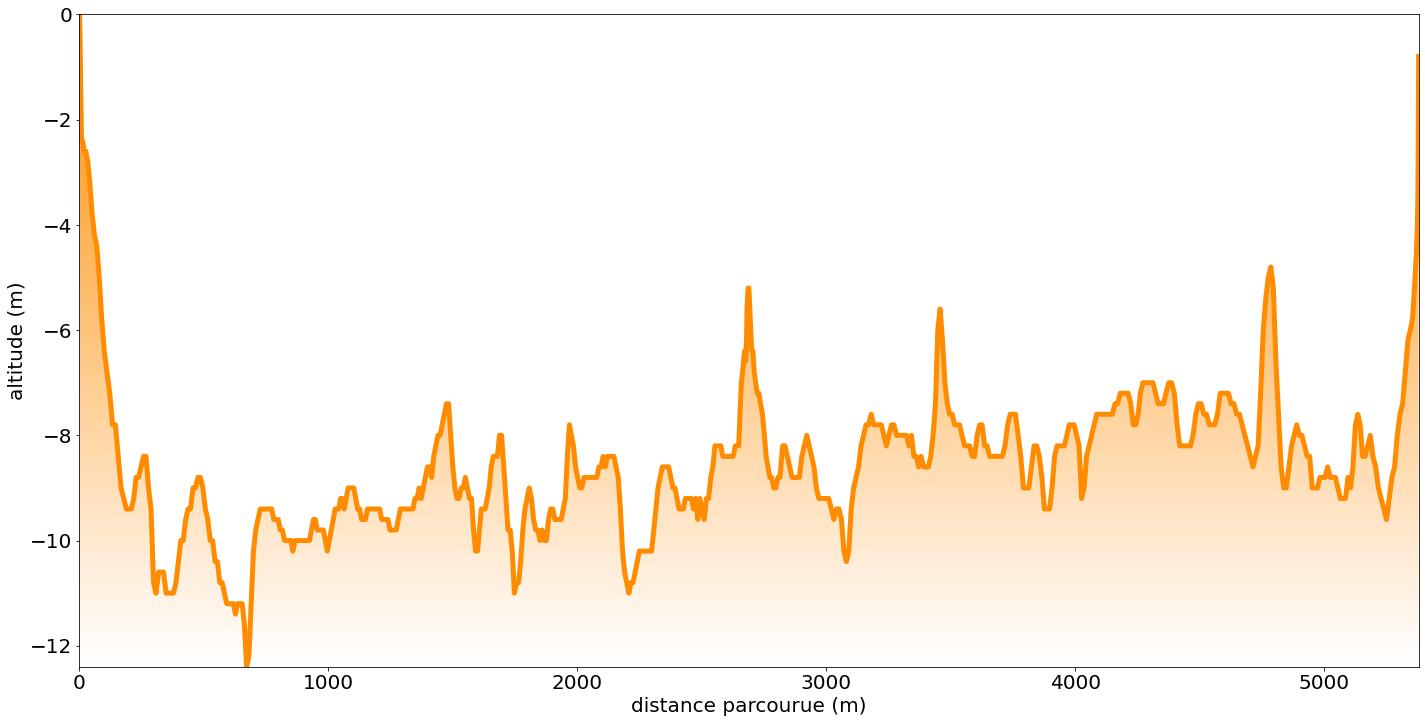

In [97]:
#start_point = 32200.
#end_point = 36400.

#afficher le profil du parcours (altitude en fonction de la distance)

v_l = np.sqrt(v_x**2 + v_y**2)
alpha = np.arctan(v_z/v_l)

#plt.plot(s/1000., z, color='darkorange', linewidth=5, linestyle='--', alpha=1.0)
gradient_fill(s,z, color='darkorange', linewidth=5)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.axvline(x=start_point)
#plt.axvline(x=end_point)
plt.xlabel('distance parcourue (m)', fontsize=20)
plt.ylabel('altitude (m)', fontsize=20)
plt.show()

#index_start, s_start = find_nearest(s, start_point) 
#index_end, s_end = find_nearest(s, end_point) 
#print(index_start, s_start, index_end, s_end)

### Expression du PFD

$$\vec{P} + \vec{R} + \vec{Fa} + \vec{Fp} = m \vec{\gamma}$$

- sur $\vec{t}$ : $-m\,g\,\textrm{sin}\,\alpha + R_t - \frac{1}{2}\,\rho\,S\,C_x\,\nu^2 = m\,\gamma_t$ 
- sur $\vec{n}$ : $R_n = m\,\gamma_n$
- sur $\vec{b}$ : $R_b - m\,g\,\textrm{cos} \alpha = m\,\gamma_b$


In [98]:
#Calcul des efforts
rho_air=1.1
S=0.45
Cx=0.825
m = 73. #kg
g = 9.81 #m.s^-2
mu = 0.004

gamma_t = np.gradient(v,t)

#Dans le repère local de la trajectoire:
#Force liée au frottement de l'air Fa
Fa_t = -0.5*rho_air*S*Cx*(v)**2
Fa_n = np.zeros(len(v))
Fa_b = np.zeros(len(v))

#Poids
P_t = -m*g*np.sin(alpha)
P_n = np.zeros(len(v))
P_b = -m*g*np.cos(alpha)

#Reaction du sol
R_b = m*g*np.cos(alpha) #+ m*gamma_b
R_t = mu*R_b
R_n = np.zeros(len(v)) #m*gamma_n

#Force de poussee sur t
Fp = -P_t - R_t - Fa_t + m*gamma_t


## Affichage des Efforts

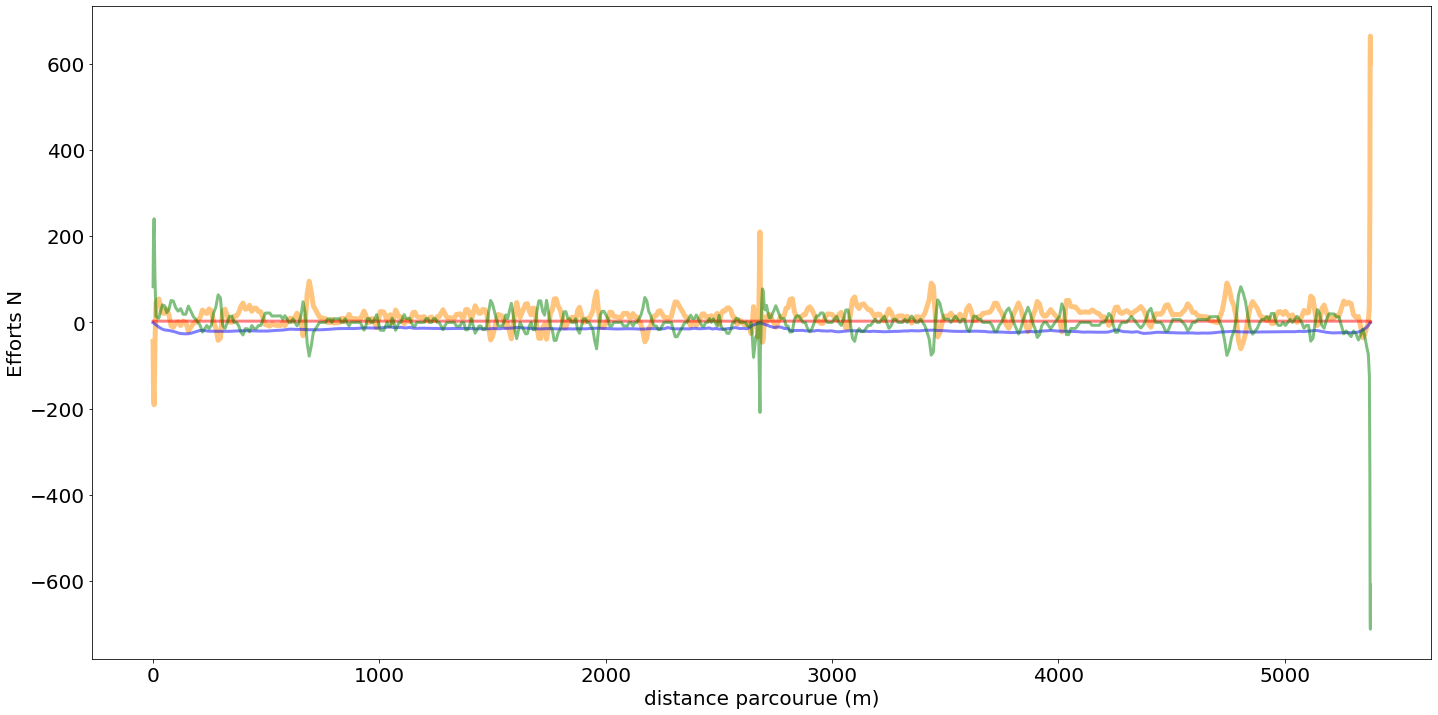

In [99]:

plt.plot(s,Fp,color='darkorange', linewidth=5, alpha=0.5)
plt.plot(s,Fa_t,color='blue', linewidth=3, alpha=0.5)
plt.plot(s,R_t,color='red', linewidth=3, alpha=0.5)
plt.plot(s,P_t,color='green', linewidth=3, alpha=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.axvline(x=start_point)
#plt.axvline(x=end_point)
plt.xlabel('distance parcourue (m)', fontsize=20)
plt.ylabel('Efforts N', fontsize=20)
plt.show()


## Calcul des Puissances

In [100]:
#Calcul des puissances

Puissance_Poids = P_t*v
Puissance_air = Fa_t*v
Puissance_react = R_t*v
P_inertie = m*gamma_t*v

#Puissance_tot = Puissance_Poids + Puissance_air + Puissance_react
Puissance_tot = Puissance_air + Puissance_react + P_inertie

P_tot_mot = np.abs(-Puissance_tot)

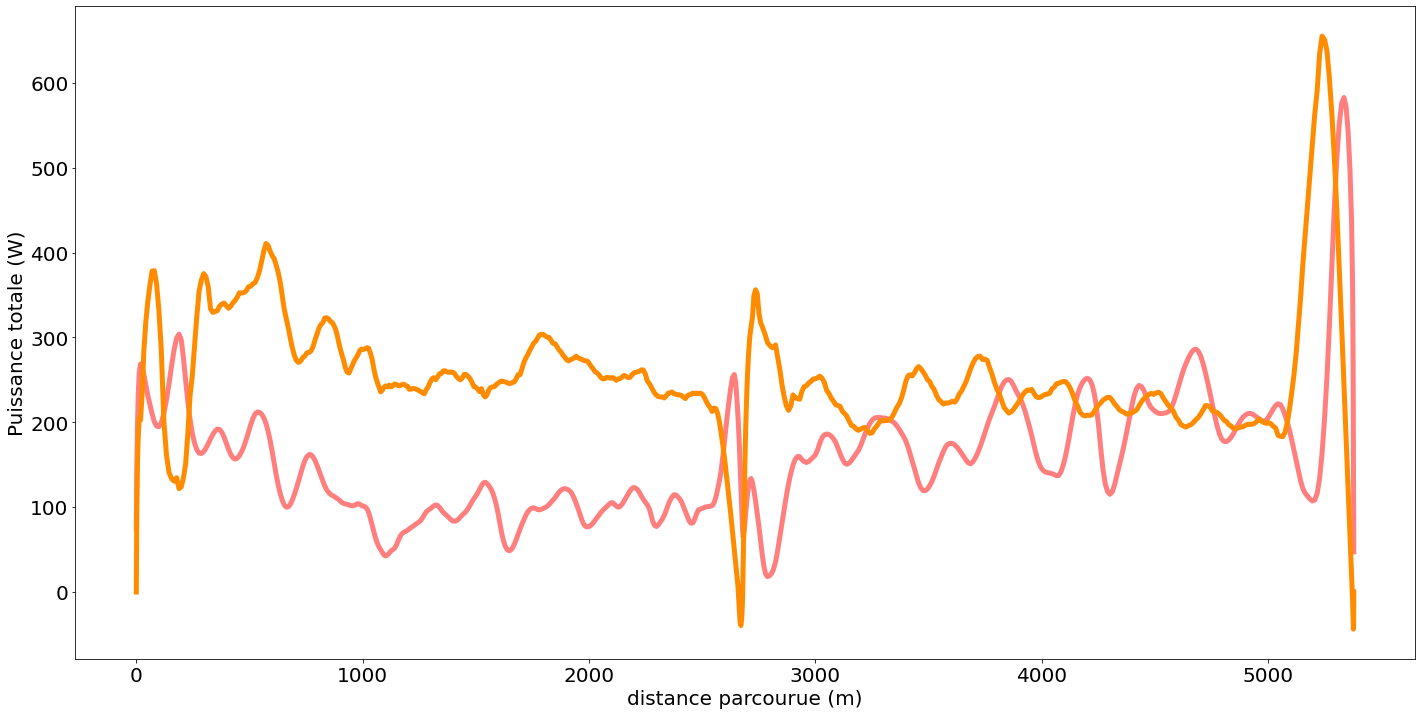

In [102]:
filter_P_tot_mot = savitzky_golay(P_tot_mot, 21, 3)
filter_watts = savitzky_golay(df['watts'].values, 21, 3)

plt.plot(s,filter_P_tot_mot,color='red', linewidth=5, alpha=0.5)
plt.plot(s,filter_watts, color='darkorange', linewidth=5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.axvline(x=start_point)
#plt.axvline(x=end_point)
plt.xlabel('distance parcourue (m)', fontsize=20)
plt.ylabel('Puissance totale (W)', fontsize=20)
plt.show()

In [ ]:
#P_tot_mot_montee = P_tot_mot[index_start:index_end]
#print(len(P_tot_mot_montee))
#P_avg = np.average(P_tot_mot_montee)
#print(P_avg)

## Calcul de l'intensité des vibrations

In [103]:
accelerometer_name = 'transfer_run2/Accelerometer.csv'
acc = pd.read_csv(accelerometer_name, sep='\t')
acc.columns = ['time', 'a_x', 'a_y', 'a_z']


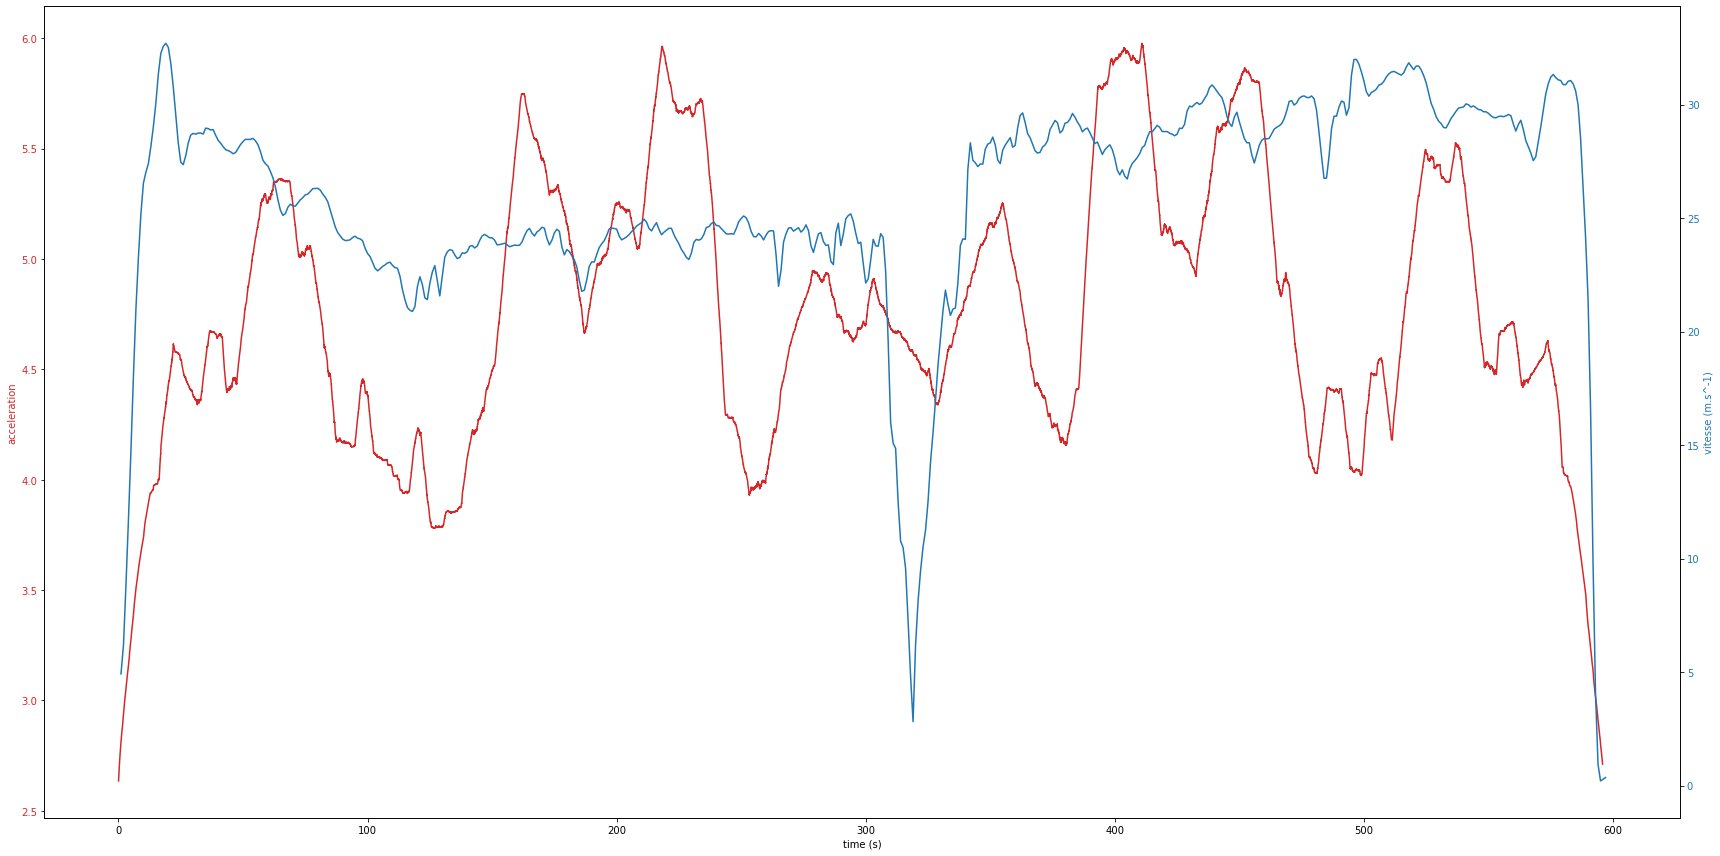

In [106]:
t_acc = acc['time'].values
a_x_acc = acc['a_x'].values
a_y_acc = acc['a_y'].values
a_z_acc = acc['a_z'].values
a_norm_acc = np.sqrt(a_x_acc**2. + a_y_acc**2. + a_z_acc**2)

a2 = a_x_acc**2. + a_y_acc**2. + a_z_acc**2
def window_rms(a2, window_size):
  window = np.ones(window_size)/float(window_size)
  return np.sqrt(np.convolve(a2, window, 'same'))

fig, ax1 = plt.subplots()

a_rms_10000 = window_rms(a_norm_acc, 10000)

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('acceleration', color=color)
ax1.plot(t_acc,a_rms_10000, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('vitesse (m.s^-1)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, Puissance_react, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
